In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import copy
from typing import (
    Dict, 
    List,
    Any
)

import mlflow
from datetime import datetime


import numpy as np
import pandas as pd

from scipy.stats import uniform
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit

from joblib import load, dump

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
sys.path.append(os.path.join(os.getcwd(), '..'))
from utils.metrics import Metrics
from utils.modelling_tools import (
    search_hyper_params_and_log, 
    update_solver_by_penalty, 
    evaluate_model,
)
from utils.metrics_by_quantile import MetricsByQuantile

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [4]:
RUN_NAME: str = 'LogRegression-no-marital-hyperparams_tunning - 1'

In [5]:
PROJECT_PATH: str = os.path.join(os.getcwd(), '..')
DATA_PATH: str = os.path.join(PROJECT_PATH, 'data')
OPT_BIN_PATH: str = os.path.join(os.path.join(PROJECT_PATH, 'objects'), 'optbinners')
MODELS_PATH: str = os.path.join(os.path.join(PROJECT_PATH, 'objects'), 'models')

In [6]:
TRAIN_FROM: datetime.date = pd.to_datetime('2021-12-01').date()
TRAIN_TO: datetime.date = pd.to_datetime('2022-01-01').date()

VAL_FROM: datetime.date = pd.to_datetime('2023-01-01').date()
VAL_TO: datetime.date = pd.to_datetime('2023-05-01').date()

TEST_FROM: datetime.date = pd.to_datetime('2023-05-01').date()
TEST_TO: datetime.date = pd.to_datetime('2023-08-01').date()

In [7]:
# set constants
COLS_TO_USE: List[str] = [
'OPTIN_11SCN_MLOptBin',
'G5_ND_SPECIIOptBin',
# 'Marital_StatusOptBin',
'SP_F2_33OptBin',
'AFF_B_09_01OptBin',
'TRD_A_20OptBin',
'TRD_A_08OptBin',
'VM01_SP_VM2_15OptBin',
'GEN11_SP_N_92OptBin',
'SP_EDI_24OptBin',
'SP_G_37OptBin',
'E4_Q_17OptBin',
'TRD_C_07OptBin',
'TRD_B_20OptBin',
'SP_B2_18OptBin',
'SPA_F2_33OptBin',
'VM01_SP_VM2_14OptBin',
'VM01_SP_VM2_24OptBin',
'SP_G_38OptBin',
'TRD_O_05OptBin',
'E1_A_09OptBin',
'TRD_O_07OptBin',
'ND_INC_03OptBin',
'VM01_SP_VM2_17OptBin',
'SP_B1_14OptBin',
'GEN11_SP_N_91OptBin',
'GEN11_SP_EDI_07OptBin',
'ND_ECC_06OptBin',
'TRD_B_18OptBin',
'TRD_B_08OptBin',
'EA5_S_01OptBin',
'CLU_CLI_L6M_NPR_L6MOptBin',
'E1_B_06OptBin',
'SP_I_67_01OptBin',
'GEN11_SP_K_80OptBin',
'SP_I_63_01OptBin',
'E4_Q_04OptBin',
'ND_ECC_04OptBin',
'VM08_SP_VM2_15OptBin',
'VAL_DELINQ_ACCSOptBin',
'ND_ERL_01OptBin',
'EA1_D_02OptBin',
'ND_HAC_06OptBin',
'AFF_E_07_01OptBin',
'TRD_O_06OptBin',
'E2_G_08OptBin',
'AFF_T_07_01OptBin',
'VM02_SP_VM1_18OptBin'
]

In [8]:
TARGET_NAME: str = 'GB6_Flag_2Limit'
TARGET_VALS: List[int] = [0, 1]
TARGET_BIN: str = f'_{TARGET_NAME}_bin'

PALETTE: Dict[str, str] = {
    TARGET_NAME: {
        'G': 'green',
        'B': 'red',
        'I': 'black'
    },
    TARGET_BIN: {0: 'green', 1: 'red'},
    'DataPart': {'Train+Val': 'black', 'Val': 'blue', 'Test': 'red', 'Train': 'orange'}
}

In [9]:
N_ITER: int = 100
RANDOM_SEED: int = 42
CONFIDENCE_LEVEL = 0.05

In [10]:
MODEL = LogisticRegression

In [11]:
PARAMS: Dict[str, Any] = dict(
    penalty=['l2', 'l1', 'elasticnet'], 
    C=uniform(loc=0, scale=20), 
    fit_intercept=[True], 
    class_weight=['balanced'], 
    random_state=[RANDOM_SEED], 
    n_jobs=[-1]
)

In [12]:
# read data
df: pd.DataFrame = pd.read_csv(os.path.join(DATA_PATH, 'final_aiq2_optbins_neg_sep_I_bad.csv'), low_memory=False)

In [13]:
print('Number of rows: %.0f; columns: %.0f' % df.shape)

Number of rows: 110462; columns: 2070


# Preprocessing

Convert dates to the corresponding types

In [14]:
for col in ['_RDATE_EOM', '_RDATE']:
    df[col] = pd.to_datetime(df[col]).dt.date

In [15]:
print('Available date range:')
df['_RDATE'].agg(['min', 'max'])

Available date range:


min    2021-06-30
max    2023-11-30
Name: _RDATE, dtype: object

# Split data

In [16]:
df_train = df.loc[
    (df._RDATE >= TRAIN_FROM) &
    (df._RDATE < TRAIN_TO) & 
    (df[TARGET_NAME] != 'I'),
    COLS_TO_USE + [TARGET_NAME, TARGET_BIN, '_RDATE']
].reset_index(drop=True)

df_train_val = df.loc[
    (df._RDATE >= TRAIN_FROM) &
    (df._RDATE < VAL_TO) &
    (df[TARGET_NAME] != 'I'),
    COLS_TO_USE + [TARGET_NAME, TARGET_BIN, '_RDATE']
].reset_index(drop=True)

df_val = df.loc[
    (df._RDATE >= VAL_FROM) &
    (df._RDATE < VAL_TO) &
    (df[TARGET_NAME] != 'I'),
    COLS_TO_USE + [TARGET_NAME, TARGET_BIN, '_RDATE']
].reset_index(drop=True)

df_test_same = df.loc[
    (df._RDATE >= TEST_FROM) &
    (df._RDATE < TEST_TO) &
    (df[TARGET_NAME] != 'I'),
    COLS_TO_USE + [TARGET_NAME, TARGET_BIN, '_RDATE']
].reset_index(drop=True)

df_test = df.loc[
    (df._RDATE >= TEST_FROM) &
    (df._RDATE < TEST_TO),
    COLS_TO_USE + [TARGET_NAME, TARGET_BIN, '_RDATE']
].reset_index(drop=True)

In [17]:
data_dict = {
    "df_train": df_train,
    "df_val": df_val,
    "df_train_val": df_train_val, 
    "df_test_same": df_test_same,
    "df_test": df_test
}

In [18]:
# randomly select N observations from test data
N = 10000
sss = StratifiedShuffleSplit(n_splits=1, train_size=N, random_state=RANDOM_SEED)
indx = sss.split(data_dict['df_test_same'].reset_index(drop=True), data_dict['df_test_same'][TARGET_BIN])
random_indx = list(indx)[0][0]

assert len(random_indx) == N, "Incorrect number of elements in the subsample"
test_sample = data_dict['df_test_same'].reset_index(drop=True).iloc[random_indx, :].reset_index(drop=True)

In [19]:
data_dict['df_test_same_sample'] = test_sample

# Run the experiment

In [20]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000/")
mlflow.set_experiment("[Experian][Initial]")

<Experiment: artifact_location='mlflow-artifacts:/627889994153009057', creation_time=1717104212212, experiment_id='627889994153009057', last_update_time=1717104212212, lifecycle_stage='active', name='[Experian][Initial]', tags={}>

In [21]:
MODEL = LogisticRegression

In [22]:
experiment_description = f"""
    'features': {len(COLS_TO_USE)},
    'target': {TARGET_BIN},
    'target_vals': '0==G, 1==B',
    'model': {MODEL.__name__},
    'data_version': '22.05.2024', 
    'train_period': [{TRAIN_FROM.strftime('%Y-%m-%d') + ', ' + TRAIN_TO.strftime('%Y-%m-%d')}),
    'val_period': [{VAL_FROM.strftime('%Y-%m-%d') + ', ' + VAL_TO.strftime('%Y-%m-%d')}),
    'test_period': [{TEST_FROM.strftime('%Y-%m-%d') + ', ' + TEST_TO.strftime('%Y-%m-%d')}),
"""

In [23]:
print(experiment_description)


    'features': 47,
    'target': _GB6_Flag_2Limit_bin,
    'target_vals': '0==G, 1==B',
    'model': LogisticRegression,
    'data_version': '22.05.2024', 
    'train_period': [2021-12-01, 2022-01-01),
    'val_period': [2023-01-01, 2023-05-01),
    'test_period': [2023-05-01, 2023-08-01),



2024/06/04 15:39:28 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/06/04 15:39:28 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 1 / 100
# 2 / 100


2024/06/04 15:39:29 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/06/04 15:39:29 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 3 / 100
# 4 / 100


2024/06/04 15:39:57 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/06/04 15:39:57 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 5 / 100
# 6 / 100
# 7 / 100


2024/06/04 15:40:07 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/06/04 15:40:07 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 8 / 100


2024/06/04 15:40:15 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/06/04 15:40:15 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 9 / 100


2024/06/04 15:40:24 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/06/04 15:40:24 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 10 / 100
# 11 / 100
# 12 / 100


2024/06/04 15:40:34 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/06/04 15:40:34 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 13 / 100
# 14 / 100


2024/06/04 15:40:42 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/06/04 15:40:42 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 15 / 100


2024/06/04 15:40:49 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/06/04 15:40:49 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 16 / 100


2024/06/04 15:40:57 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/06/04 15:40:57 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 17 / 100
# 18 / 100
# 19 / 100
# 20 / 100


2024/06/04 15:41:06 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/06/04 15:41:06 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 21 / 100
# 22 / 100
# 23 / 100
# 24 / 100
# 25 / 100


2024/06/04 15:41:15 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/06/04 15:41:15 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 26 / 100
# 27 / 100
# 28 / 100


2024/06/04 15:41:29 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/06/04 15:41:29 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 29 / 100


2024/06/04 15:41:49 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/06/04 15:41:49 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 30 / 100
# 31 / 100


2024/06/04 15:42:02 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/06/04 15:42:02 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 32 / 100
# 33 / 100


2024/06/04 15:42:18 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/06/04 15:42:18 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 34 / 100
# 35 / 100
# 36 / 100
# 37 / 100
# 38 / 100
# 39 / 100
# 40 / 100


2024/06/04 15:42:30 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/06/04 15:42:30 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 41 / 100
# 42 / 100
# 43 / 100
# 44 / 100
# 45 / 100
# 46 / 100
# 47 / 100


2024/06/04 15:42:44 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/06/04 15:42:44 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 48 / 100
# 49 / 100


2024/06/04 15:42:52 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/06/04 15:42:52 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 50 / 100
# 51 / 100
# 52 / 100
# 53 / 100
# 54 / 100
# 55 / 100
# 56 / 100
# 57 / 100


2024/06/04 15:43:05 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/06/04 15:43:05 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 58 / 100


2024/06/04 15:43:13 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/06/04 15:43:13 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 59 / 100


2024/06/04 15:43:27 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/06/04 15:43:27 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 60 / 100
# 61 / 100
# 62 / 100
# 63 / 100
# 64 / 100
# 65 / 100
# 66 / 100
# 67 / 100


2024/06/04 15:43:51 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/06/04 15:43:51 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 68 / 100
# 69 / 100
# 70 / 100
# 71 / 100
# 72 / 100


2024/06/04 15:44:03 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/06/04 15:44:03 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 73 / 100


2024/06/04 15:44:18 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/06/04 15:44:18 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 74 / 100
# 75 / 100
# 76 / 100
# 77 / 100
# 78 / 100


2024/06/04 15:44:31 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/06/04 15:44:31 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 79 / 100
# 80 / 100
# 81 / 100


2024/06/04 15:44:43 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/06/04 15:44:43 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 82 / 100
# 83 / 100
# 84 / 100
# 85 / 100
# 86 / 100
# 87 / 100


2024/06/04 15:45:00 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/06/04 15:45:01 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 88 / 100


2024/06/04 15:45:12 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/06/04 15:45:12 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 89 / 100
# 90 / 100
# 91 / 100
# 92 / 100


2024/06/04 15:45:24 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/06/04 15:45:24 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 93 / 100
# 94 / 100
# 95 / 100


2024/06/04 15:45:34 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/06/04 15:45:34 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 96 / 100
# 97 / 100


2024/06/04 15:45:45 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/06/04 15:45:45 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 98 / 100


2024/06/04 15:45:54 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/06/04 15:45:54 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 99 / 100


2024/06/04 15:46:04 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/06/04 15:46:04 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 100 / 100


2024/06/04 15:46:12 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/06/04 15:46:12 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

Best params:
 {'penalty': 'l1', 'C': 2.441759094013467, 'fit_intercept': True, 'class_weight': 'balanced', 'random_state': 42, 'n_jobs': -1, 'solver': 'liblinear'}
Val-PR_AUC:  0.1164187271839281
Val-GINI:  0.46552952384579194


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.


Not saved
Test-PR_AUC 0.21255249989214603
Test-Gini 0.5617810102487366


The option feature_dependence has been renamed to feature_perturbation!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


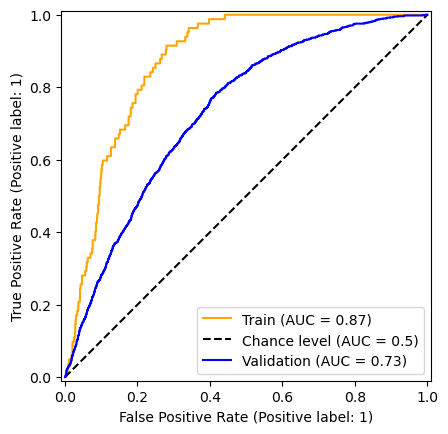

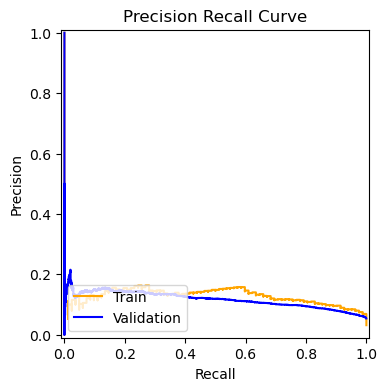

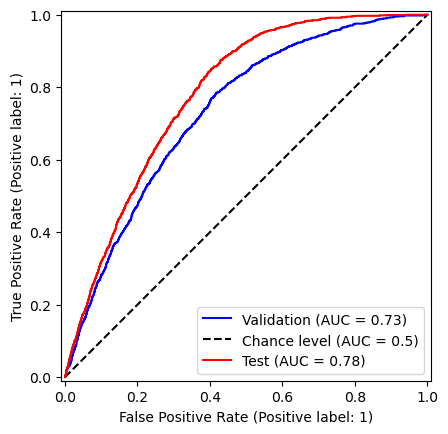

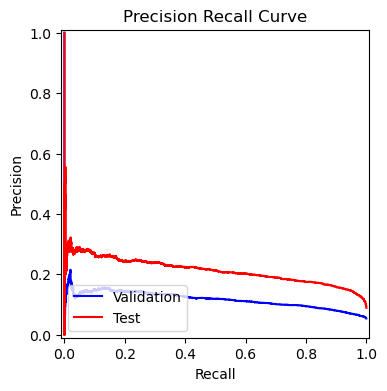

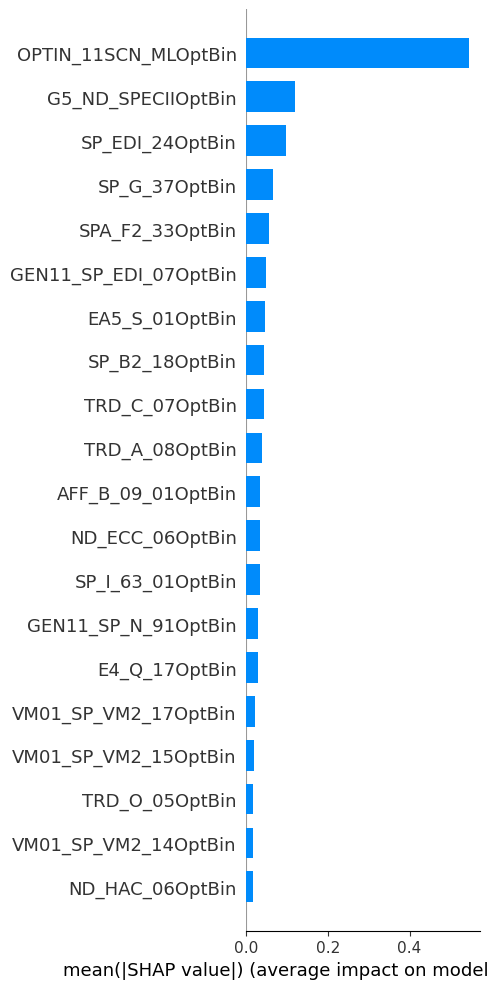

2024/06/04 15:46:52 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/06/04 15:46:52 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


In [24]:
with mlflow.start_run(run_name=RUN_NAME, log_system_metrics=True):
    res = search_hyper_params_and_log(
        run_name=RUN_NAME,
        data_dict=data_dict,
        cols_to_use=COLS_TO_USE,
        target_name=TARGET_BIN,
        distributions=PARAMS,
        n_iter=N_ITER,
        model=MODEL,
        custom_params_updates=update_solver_by_penalty,
        tags={'features': len(COLS_TO_USE)}, 
        palette=PALETTE['DataPart'],
        test_name='df_test_same',
        model_path=MODELS_PATH
    )

In [37]:
df_metrics, df_coeff, data_dict, model_obj, std_scaler = res

# Model's quality

## Coefficients

In [26]:
df_coeff.sort_values('Importance(%)', ascending=False)

,Feature,Coeff,Importance(%),p-value,Importance(SHAP),"Importance(SHAP, %)"
22,OPTIN_11SCN_MLOptBin,-0.823397,16.591473,0.000000e+00,0.545325,36.672251
16,Intercept,-0.818252,16.487808,0.000000e+00,NaN,NaN
26,SP_EDI_24OptBin,-0.319546,6.438870,0.000000e+00,0.096945,6.519385
11,G5_ND_SPECIIOptBin,-0.225709,4.548039,0.000000e+00,0.117991,7.934734
23,SPA_F2_33OptBin,-0.225016,4.534076,0.000000e+00,0.055184,3.711058
30,SP_I_63_01OptBin,-0.188060,3.789423,0.000000e+00,0.032026,2.153679
12,GEN11_SP_EDI_07OptBin,0.176570,3.557889,0.000000e+00,0.047064,3.165012
37,TRD_C_07OptBin,-0.152895,3.080840,0.000000e+00,0.042231,2.839940
28,SP_G_37OptBin,-0.141505,2.851332,0.000000e+00,0.064243,4.320229
39,TRD_O_06OptBin,0.131455,2.648817,0.000000e+00,0.014797,0.995046


In [27]:
# features with 0 coefficients
df_coeff[df_coeff.Coeff == 0]

,Feature,Coeff,Importance(%),p-value,Importance(SHAP),"Importance(SHAP, %)"


In [28]:
# features with high p-value
df_coeff[df_coeff['p-value'] > CONFIDENCE_LEVEL]

,Feature,Coeff,Importance(%),p-value,Importance(SHAP),"Importance(SHAP, %)"
1,AFF_E_07_01OptBin,-0.011716,0.236073,0.411841,0.001639,0.110248
4,E1_A_09OptBin,0.001291,0.026013,0.936753,0.000491,0.033032
15,GEN11_SP_N_92OptBin,-0.028148,0.567175,0.075202,0.011554,0.777001
27,SP_F2_33OptBin,0.007454,0.150205,0.658112,0.003292,0.221415
29,SP_G_38OptBin,-0.010723,0.216067,0.544110,0.004366,0.293598
31,SP_I_67_01OptBin,-0.008649,0.174287,0.490015,0.001389,0.093402
33,TRD_A_20OptBin,0.012995,0.261845,0.181172,0.000003,0.000220
34,TRD_B_08OptBin,-0.011555,0.232827,0.311844,0.000546,0.036740
36,TRD_B_20OptBin,-0.018092,0.364556,0.161657,0.002961,0.199132
40,TRD_O_07OptBin,-0.015109,0.304456,0.230244,0.002871,0.193044


In [29]:
# features with p-values low than the confident level
for col in COLS_TO_USE:
    if col not in df_coeff[df_coeff['p-value'] > CONFIDENCE_LEVEL].Feature.values:
        print(f'"{col}",')

"OPTIN_11SCN_MLOptBin",
"G5_ND_SPECIIOptBin",
"AFF_B_09_01OptBin",
"TRD_A_08OptBin",
"VM01_SP_VM2_15OptBin",
"SP_EDI_24OptBin",
"SP_G_37OptBin",
"E4_Q_17OptBin",
"TRD_C_07OptBin",
"SP_B2_18OptBin",
"SPA_F2_33OptBin",
"VM01_SP_VM2_14OptBin",
"VM01_SP_VM2_24OptBin",
"TRD_O_05OptBin",
"ND_INC_03OptBin",
"VM01_SP_VM2_17OptBin",
"SP_B1_14OptBin",
"GEN11_SP_N_91OptBin",
"GEN11_SP_EDI_07OptBin",
"ND_ECC_06OptBin",
"TRD_B_18OptBin",
"EA5_S_01OptBin",
"CLU_CLI_L6M_NPR_L6MOptBin",
"E1_B_06OptBin",
"GEN11_SP_K_80OptBin",
"SP_I_63_01OptBin",
"E4_Q_04OptBin",
"ND_ECC_04OptBin",
"VM08_SP_VM2_15OptBin",
"ND_ERL_01OptBin",
"EA1_D_02OptBin",
"ND_HAC_06OptBin",
"TRD_O_06OptBin",
"E2_G_08OptBin",
"AFF_T_07_01OptBin",
"VM02_SP_VM1_18OptBin",


## GINI, AU PRC

## Test-same

In [30]:
evaluate_model(
    data=data_dict['df_test_same'], 
    cols_to_use=COLS_TO_USE,
    std_scaler=std_scaler,
    target_name=TARGET_BIN,
    model_obj=model_obj
)

Test-PR_AUC 0.21255249989214603
Test-Gini 0.5617810102487366


## Test-full

In [31]:
evaluate_model(
    data=data_dict['df_test'], 
    cols_to_use=COLS_TO_USE,
    std_scaler=std_scaler,
    target_name=TARGET_BIN,
    model_obj=model_obj
)

Test-PR_AUC 0.1807394693952229
Test-Gini 0.5252138470913466


## Outcomes distributions

In [32]:
data_dict['df_test']['score'] = model_obj.predict_proba(
    std_scaler.transform(data_dict['df_test'][COLS_TO_USE])
)[:, 1]

### Test-same

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


<Axes: xlabel='score', ylabel='Density'>

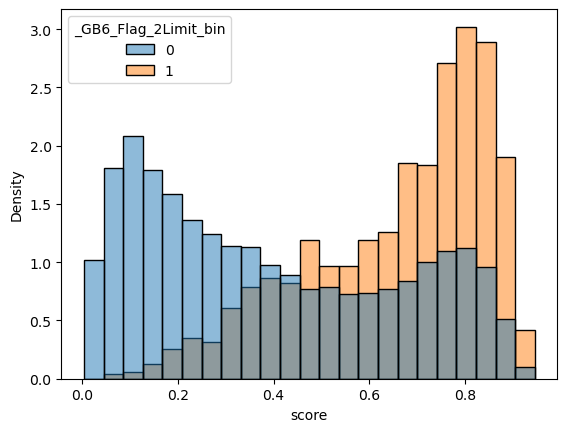

In [33]:
sns.histplot(x=data_dict['df_test_same']['score'], hue=data_dict['df_test_same'][TARGET_BIN], common_norm=False, stat='density')

### Test-full

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


<Axes: xlabel='score', ylabel='Density'>

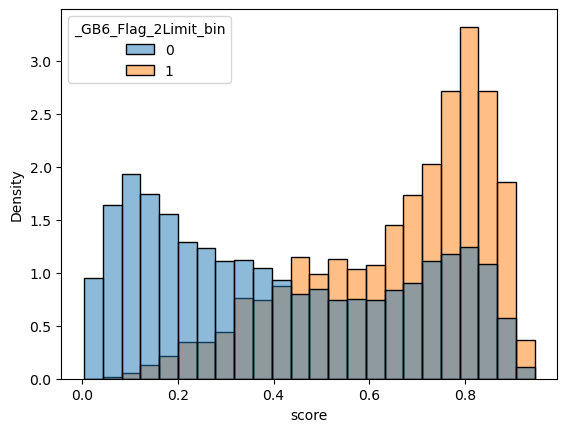

In [34]:
sns.histplot(x=data_dict['df_test']['score'], hue=data_dict['df_test'][TARGET_BIN], common_norm=False, stat='density')

## Precision, Recall By Quantile

### Test-same

In [35]:
m = MetricsByQuantile(metrics=["quantiles_analytics"])
r = m.compute(
    y_true=data_dict['df_test_same'][TARGET_BIN].reset_index(drop=True), 
    y_pred=data_dict['df_test_same']['score'].round(3).reset_index(drop=True), 
    list_of_metrics = [
        "cum_precision_by_quantile", "cum_recall_by_quantile", 
        "precision_by_quantile", "recall_by_quantile",
    ], 
    n_quantiles = 200
)
df_deciles = r["other"]["quantiles_analytics"]
df_deciles.head(50)

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,% of total population,Cumulative % of total population,Total,Bad,Cumulative Bad,Quantile,#Quantile,Cumulative Precision,Cumulative Recall,Precision,Recall,Scores
0,0.50,0.50,75,22,22,"(0.905, 0.946]",200,29.333333,1.649175,29.333333,1.649175,0.905--0.946
1,0.49,0.99,74,18,40,"(0.893, 0.905]",199,26.845638,2.998501,24.324324,1.349325,0.893--0.905
2,0.45,1.45,68,22,62,"(0.884, 0.893]",198,28.571429,4.647676,32.352941,1.649175,0.884--0.893
3,0.55,1.99,82,21,83,"(0.876, 0.884]",197,27.759197,6.221889,25.609756,1.574213,0.876--0.884
4,0.43,2.43,65,19,102,"(0.871, 0.876]",196,28.021978,7.646177,29.230769,1.424288,0.871--0.876
5,0.52,2.95,78,18,120,"(0.865, 0.871]",195,27.149321,8.995502,23.076923,1.349325,0.865--0.871
6,0.49,3.44,74,15,135,"(0.86, 0.865]",194,26.162791,10.119940,20.270270,1.124438,0.86--0.865
7,0.52,3.96,78,19,154,"(0.855, 0.86]",193,25.925926,11.544228,24.358974,1.424288,0.855--0.86
8,0.52,4.48,78,21,175,"(0.85, 0.855]",192,26.041667,13.118441,26.923077,1.574213,0.85--0.855
9,0.41,4.89,62,17,192,"(0.846, 0.85]",191,26.158038,14.392804,27.419355,1.274363,0.846--0.85


### Test-full

In [36]:
m = MetricsByQuantile(metrics=["quantiles_analytics"])
r = m.compute(
    y_true=data_dict['df_test'][TARGET_BIN].reset_index(drop=True), 
    y_pred=data_dict['df_test']['score'].round(3).reset_index(drop=True), 
    list_of_metrics = [
        "cum_precision_by_quantile", "cum_recall_by_quantile", 
        "precision_by_quantile", "recall_by_quantile",
    ], 
    n_quantiles = 200
)
df_deciles = r["other"]["quantiles_analytics"]
df_deciles.head(50)

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,% of total population,Cumulative % of total population,Total,Bad,Cumulative Bad,Quantile,#Quantile,Cumulative Precision,Cumulative Recall,Precision,Recall,Scores
0,0.48,0.48,78,19,19,"(0.907, 0.946]",200,24.358974,1.424288,24.358974,1.424288,0.907--0.946
1,0.50,0.99,82,17,36,"(0.896, 0.907]",199,22.500000,2.698651,20.731707,1.274363,0.896--0.907
2,0.47,1.46,77,20,56,"(0.887, 0.896]",198,23.628692,4.197901,25.974026,1.499250,0.887--0.896
3,0.53,1.99,86,18,74,"(0.879, 0.887]",197,22.910217,5.547226,20.930233,1.349325,0.879--0.887
4,0.49,2.48,80,16,90,"(0.873, 0.879]",196,22.332506,6.746627,20.000000,1.199400,0.873--0.879
5,0.49,2.97,79,20,110,"(0.869, 0.873]",195,22.821577,8.245877,25.316456,1.499250,0.869--0.873
6,0.47,3.44,76,13,123,"(0.864, 0.869]",194,22.043011,9.220390,17.105263,0.974513,0.864--0.869
7,0.52,3.96,85,13,136,"(0.859, 0.864]",193,21.150855,10.194903,15.294118,0.974513,0.859--0.864
8,0.52,4.48,85,18,154,"(0.855, 0.859]",192,21.153846,11.544228,21.176471,1.349325,0.855--0.859
9,0.49,4.97,79,19,173,"(0.851, 0.855]",191,21.437423,12.968516,24.050633,1.424288,0.851--0.855
